In [33]:
from IPython import display
import numpy as np
from matplotlib import pyplot as plt
import progressbar
import torch
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.utils as vutils
from torchvision import transforms, datasets

In [34]:
OUTPUT_DIR = './data/CIFAR-10'
BATCH_SIZE = 100
LR = 0.0002
NUM_EPOCHS = 200
NUM_TEST_SAMPLES = 32

In [35]:
def load_data():
    compose = transforms.Compose(
        [
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    return datasets.CIFAR10(root=OUTPUT_DIR, train=True, transform=compose, download=True)

data = load_data()
# data = torch.utils.data.Subset(data, [0, 5000])
data_loader = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)
NUM_BATCHES = len(data_loader)

print("No. of Batches = ", NUM_BATCHES)

Files already downloaded and verified
No. of Batches =  500


In [36]:
class Discriminator(torch.nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False), nn.LeakyReLU(0.2, inplace=True))
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False), nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True))
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False), nn.BatchNorm2d(512), nn.LeakyReLU(0.2, inplace=True))
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1, bias=False), nn.BatchNorm2d(1024), nn.LeakyReLU(0.2, inplace=True))
        self.output = nn.Sequential(nn.Linear(1024*4*4, 1), nn.Sigmoid())

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # Flatten and apply sigmoid
        x = x.view(-1, 1024*4*4)
        x = self.output(x)
        return x

In [37]:
class Generator(torch.nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        self.linear = torch.nn.Linear(100, 1024*4*4)
        self.deconv1 = nn.Sequential(nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(inplace=True))
        self.deconv2 = nn.Sequential(nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(inplace=True))
        self.deconv3 = nn.Sequential(nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False), nn.BatchNorm2d(128), nn.ReLU(inplace=True))
        self.deconv4 = nn.Sequential(nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False))
        self.output = torch.nn.Tanh()

    def forward(self, x):
        # Project and reshape
        x = self.linear(x)
        x = x.view(x.shape[0], 1024, 4, 4)

        # Convolutional layers
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)

        # Apply Tanh
        return self.output(x)

In [38]:
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available():
      return n.cuda()
    return n

In [39]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

In [40]:
generator = Generator()
discriminator = Discriminator()
generator.apply(init_weights)
discriminator.apply(init_weights)

# Enable cuda if available
if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()

In [41]:
# d_optimizer = optim.SGD(discriminator.parameters(), lr=LR, momentum=0.9)
# g_optimizer = optim.SGD(generator.parameters(), lr=LR, momentum=0.9)
d_optimizer = optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))

# Loss function
# criterion = nn.MSELoss()
criterion = nn.BCELoss()

## Use Adam Optimizer with BCELoss function


In [42]:
def real_data_target(size):
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available():
      return data.cuda()
    return data

def fake_data_target(size):
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available():
      return data.cuda()
    return data

In [43]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()

    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = criterion(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = criterion(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()

    # 1.3 Update weights with gradients
    optimizer.step()

    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = criterion(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [44]:
test_noise = noise(NUM_TEST_SAMPLES)

In [45]:
def generate_images(test_images, num_images, normalize=True):
  images = test_images

  # Make horizontal grid from image tensor
  horizontal_grid = vutils.make_grid(images, normalize=normalize, scale_each=True)
  # Make vertical grid from image tensor
  nrows = int(np.sqrt(num_images))
  grid = vutils.make_grid(images, nrow=nrows, normalize=True, scale_each=True)

  # Plot and save horizontal
  fig = plt.figure(figsize=(16, 16))
  plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
  plt.axis('off')
  if True:
    display.display(plt.gcf())
  plt.close()

  # Save squared
  fig = plt.figure()
  plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
  plt.axis('off')
  plt.close()

In [46]:
for epoch in range(NUM_EPOCHS):
  print("\nEpoch #", epoch, "in progress...")
  progress_bar = progressbar.ProgressBar()
  d_running_loss = 0
  g_running_loss = 0

  for n_batch, (real_batch, _) in enumerate(progress_bar(data_loader)):
    # 1. Train Discriminator
#     inputs, _ = real_batch
    real_data = Variable(real_batch)
    if torch.cuda.is_available():
      real_data = real_data.cuda()
    # Generate fake data
    fake_data = generator(noise(real_data.size(0))).detach()
    # Train D
    d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)

    # 2. Train Generator
    # Generate fake data
    fake_data = generator(noise(real_batch.size(0)))
    # Train G
    g_error = train_generator(g_optimizer, fake_data)

    d_running_loss += d_error.item()
    g_running_loss += g_error.item()


#     loss = criterion(outputs, inputs)
  print("Loss (Discriminator):", d_running_loss)
  print("Loss (Generator):", g_running_loss)

  test_images = generator(test_noise).data.cpu()
  #generate_images(test_images, NUM_TEST_SAMPLES)

  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Epoch # 0 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:50 Time:  0:03:50
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 326.25553275458515
Loss (Generator): 1515.6131291389465

Epoch # 1 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:57 Time:  0:03:57
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 448.0983082950115
Loss (Generator): 1094.0552459657192

Epoch # 2 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:56 Time:  0:03:56
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 495.13021898269653
Loss (Generator): 919.0302872955799

Epoch # 3 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:56 Time:  0:03:56
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 465.971343934536
Loss (Generator): 966.5988079681993

Epoch # 4 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:56 Time:  0:03:56
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 443.5165404379368
Loss (Generator): 1015.8704783469439

Epoch # 5 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:56 Time:  0:03:56
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 440.60427559912205
Loss (Generator): 993.2695704996586

Epoch # 6 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:56 Time:  0:03:56
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 441.9951656758785
Loss (Generator): 1008.9961209408939

Epoch # 7 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:56 Time:  0:03:56
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 429.92908407747746
Loss (Generator): 1002.793560128659

Epoch # 8 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:56 Time:  0:03:56
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 425.58382020145655
Loss (Generator): 1052.1203277781606

Epoch # 9 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:56 Time:  0:03:56
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 375.37683172896504
Loss (Generator): 1159.6977292448282

Epoch # 10 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:56 Time:  0:03:56
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 397.4396824091673
Loss (Generator): 1124.0716918110847

Epoch # 11 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:56 Time:  0:03:56
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 365.6492846868932
Loss (Generator): 1203.9997043088078

Epoch # 12 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:56 Time:  0:03:56
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 344.55163230746984
Loss (Generator): 1244.039170615375

Epoch # 13 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:56 Time:  0:03:56
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 358.28430389612913
Loss (Generator): 1182.4356163032353

Epoch # 14 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:56 Time:  0:03:56
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 323.1536450907588
Loss (Generator): 1289.4523817673326

Epoch # 15 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:56 Time:  0:03:56
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 321.61713773943484
Loss (Generator): 1296.4243245633552

Epoch # 16 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:56 Time:  0:03:56
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 293.10307060554624
Loss (Generator): 1450.6435069246218

Epoch # 17 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:56 Time:  0:03:56
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 303.98087165132165
Loss (Generator): 1324.1196545660496

Epoch # 18 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:56 Time:  0:03:56
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 393.9484171885997
Loss (Generator): 1155.4794231653214

Epoch # 19 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:56 Time:  0:03:56
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 273.681794622913
Loss (Generator): 1417.5653613880277

Epoch # 20 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:56 Time:  0:03:56
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 290.9787723599002
Loss (Generator): 1424.1570880068466

Epoch # 21 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 284.2200969448313
Loss (Generator): 1444.6880576680414

Epoch # 22 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:56 Time:  0:03:56
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 298.6547925081104
Loss (Generator): 1416.3290037885308

Epoch # 23 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 282.8621855825186
Loss (Generator): 1428.0272835867945

Epoch # 24 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:56 Time:  0:03:56
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 276.97609546687454
Loss (Generator): 1449.030955016613

Epoch # 25 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 279.1776422020048
Loss (Generator): 1467.37777698203

Epoch # 26 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 192.29499416681938
Loss (Generator): 1753.1238867975771

Epoch # 27 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:56 Time:  0:03:56
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 277.73238147678785
Loss (Generator): 1582.510984685272

Epoch # 28 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 237.05656790360808
Loss (Generator): 1631.788880906999

Epoch # 29 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:56 Time:  0:03:56
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 241.33680013008416
Loss (Generator): 1578.89988514781

Epoch # 30 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 266.54593658261
Loss (Generator): 1497.293788805604

Epoch # 31 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 202.1079478058964
Loss (Generator): 1728.87400393188

Epoch # 32 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 210.2407308809925
Loss (Generator): 1830.7467243541032

Epoch # 33 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 226.70716135390103
Loss (Generator): 1642.407969828695

Epoch # 34 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 153.60828490974382
Loss (Generator): 2000.544527166523

Epoch # 35 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 241.0507601145655
Loss (Generator): 1580.7144127488136

Epoch # 36 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 209.12434149114415
Loss (Generator): 1763.92299760459

Epoch # 37 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:56 Time:  0:03:56
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 212.57942438777536
Loss (Generator): 1716.9792738556862

Epoch # 38 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 190.48675679089502
Loss (Generator): 1911.87250383012

Epoch # 39 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 246.4368087965995
Loss (Generator): 1627.4058299064636

Epoch # 40 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:56 Time:  0:03:56
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 224.0909295147285
Loss (Generator): 1679.6718777846545

Epoch # 41 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 198.78646449092776
Loss (Generator): 1741.466149508953

Epoch # 42 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 166.59938397607766
Loss (Generator): 1964.5696048000827

Epoch # 43 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 187.1260040672496
Loss (Generator): 1913.2071190173738

Epoch # 44 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 169.86956471251324
Loss (Generator): 1969.8385192994028

Epoch # 45 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 136.1911641168408
Loss (Generator): 2247.2645716986153

Epoch # 46 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 191.42593449447304
Loss (Generator): 1849.7709271535277

Epoch # 47 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 158.3355339349946
Loss (Generator): 2147.4350478053093

Epoch # 48 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 196.5349497590214
Loss (Generator): 1805.8365083839744

Epoch # 49 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 128.77295536221936
Loss (Generator): 2128.0705702602863

Epoch # 50 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 192.62438178947195
Loss (Generator): 1870.106351442635

Epoch # 51 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 187.51988348388113
Loss (Generator): 1964.882069669664

Epoch # 52 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 190.44517630664632
Loss (Generator): 1844.7366412874544

Epoch # 53 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 178.1868692454882
Loss (Generator): 1979.719975911008

Epoch # 54 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 141.74290819978341
Loss (Generator): 1957.2045193985105

Epoch # 55 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 184.63031153415795
Loss (Generator): 2011.696105432231

Epoch # 56 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 145.41893322067335
Loss (Generator): 2102.692199731129

Epoch # 57 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 195.34526874357834
Loss (Generator): 1757.3054321706295

Epoch # 58 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:56 Time:  0:03:56
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 169.07363292365335
Loss (Generator): 2063.298626601696

Epoch # 59 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 136.61286540701985
Loss (Generator): 2127.7885836437345

Epoch # 60 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 149.86551565723494
Loss (Generator): 1975.505299180746

Epoch # 61 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 154.81360657536425
Loss (Generator): 2186.0469555791933

Epoch # 62 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 131.85269963764586
Loss (Generator): 2137.1640806794167

Epoch # 63 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 200.58105994365178
Loss (Generator): 1813.4259177446365

Epoch # 64 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 55.21161028370261
Loss (Generator): 2559.9570336937904

Epoch # 65 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 176.38176405616105
Loss (Generator): 1900.4257514625788

Epoch # 66 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 125.05042859050445
Loss (Generator): 2295.960537531413

Epoch # 67 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 13.086057746986626
Loss (Generator): 3244.84092605114

Epoch # 68 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 1.5663513742401847
Loss (Generator): 4013.066453933716

Epoch # 69 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:55 Time:  0:03:55
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 0.30586770458148216
Loss (Generator): 12196.179814338684

Epoch # 70 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:50 Time:  0:03:50
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 15416.613500555493
Loss (Generator): 13045.724427223206

Epoch # 71 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 72 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 73 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 74 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 75 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 76 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 77 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 78 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 79 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 80 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 81 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 82 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 83 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 84 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 85 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 86 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 87 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 88 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 89 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 90 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 91 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 92 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 93 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 94 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 95 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 96 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 97 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:36 Time:  0:03:36
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 98 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 99 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:38 Time:  0:03:38
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 100 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:38 Time:  0:03:38
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 101 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 102 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 103 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 104 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 105 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 106 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 107 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 108 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 109 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 110 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 111 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 112 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 113 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 114 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:38 Time:  0:03:38
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 115 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:38 Time:  0:03:38
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 116 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:38 Time:  0:03:38
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 117 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 118 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 119 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 120 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 121 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 122 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 123 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 124 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 125 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 126 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 127 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 128 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 129 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 130 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 131 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 132 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 133 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 134 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 135 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 136 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 137 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 138 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 139 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:38 Time:  0:03:38
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 140 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 141 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 142 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 143 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:38 Time:  0:03:38
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 144 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 145 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 146 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 147 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 148 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 149 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 150 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 151 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 152 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 153 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 154 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 155 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 156 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 157 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 158 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 159 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 160 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 161 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 162 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 163 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 164 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 165 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:38 Time:  0:03:38
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 166 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 167 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 168 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 169 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 170 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:38 Time:  0:03:38
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 171 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 172 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:38 Time:  0:03:38
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 173 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 174 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 175 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 176 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 177 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 178 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 179 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 180 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 181 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 182 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 183 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 184 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 185 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 186 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 187 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 188 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:38 Time:  0:03:38
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 189 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 190 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 191 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 192 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:38 Time:  0:03:38
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 193 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 194 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:38 Time:  0:03:38
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 195 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 196 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 197 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 198 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37
  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss (Discriminator): 50000.0
Loss (Generator): 0.0

Epoch # 199 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:03:37 Time:  0:03:37


Loss (Discriminator): 50000.0
Loss (Generator): 0.0


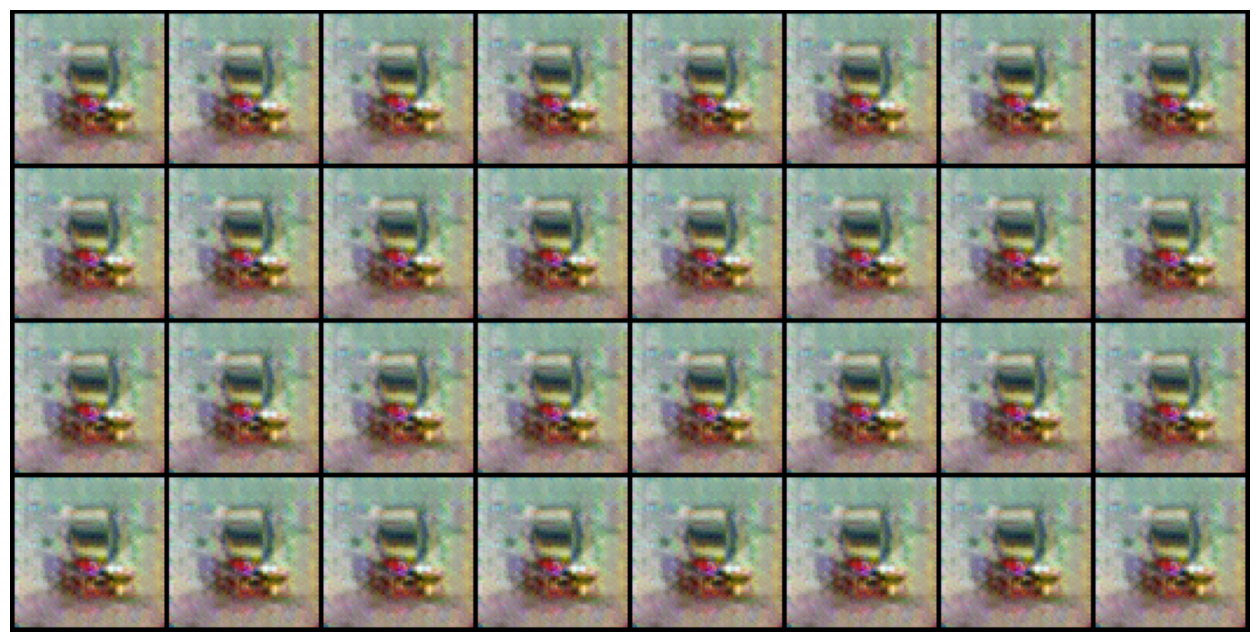

In [47]:
num_samples = NUM_TEST_SAMPLES
test_noise = noise(num_samples)
test_images = generator(test_noise).data.cpu()
generate_images(test_images, NUM_TEST_SAMPLES)

# Report

In [ ]:
Report can be found at "../report/main.pdf"